In [88]:
%matplotlib notebook
from ipynb.fs.defs.utilities import *

In [89]:
# Customized color bar 1 (2 colors)

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(70/256, 177/256, N)
vals[:, 1] = np.linspace(130/256, 78/256, N)
vals[:, 2] = np.linspace(180/256, 132/256, N)
newcmp = ListedColormap(vals)

# Customized color bar 2 (3 colors)
 
vals = np.ones((N, 4))
vals_seg1 = np.ones((N, 4))
vals_seg2 = np.ones((N, 4))

col1 = [70, 130, 180]
col2 = [214, 244, 255]
col3 = [227, 158, 33]
 
vals_seg1[:, 0] = np.linspace(col1[0]/256, col2[0]/256, N)
vals_seg1[:, 1] = np.linspace(col1[1]/256, col2[1]/256, N)
vals_seg1[:, 2] = np.linspace(col1[2]/256, col2[2]/256, N)

vals_seg2[:, 0] = np.linspace(col2[0]/256, col3[0]/256, N)
vals_seg2[:, 1] = np.linspace(col2[1]/256, col3[1]/256, N)
vals_seg2[:, 2] = np.linspace(col2[2]/256, col3[2]/256, N)

vals = np.concatenate((vals_seg1,vals_seg2))

cmp_blue_3col = ListedColormap(vals)
cmp_blue_3col_inv = ListedColormap(cmp_blue_3col.colors[::-1])

# Customized color bar 3 (4 colors)

vals = np.ones((N, 4))
vals_seg1 = np.ones((N, 4))
vals_seg2 = np.ones((N, 4))
vals_seg3 = np.ones((N, 4))

col1 = [70, 130, 180]
col2 = [227, 158, 33]
col3 = [255, 236, 203]
col4 = [138, 115, 86]
 
vals_seg1[:, 0] = np.linspace(col1[0]/256, col2[0]/256, N)
vals_seg1[:, 1] = np.linspace(col1[1]/256, col2[1]/256, N)
vals_seg1[:, 2] = np.linspace(col1[2]/256, col2[2]/256, N)

vals_seg2[:, 0] = np.linspace(col2[0]/256, col3[0]/256, N)
vals_seg2[:, 1] = np.linspace(col2[1]/256, col3[1]/256, N)
vals_seg2[:, 2] = np.linspace(col2[2]/256, col3[2]/256, N)

vals_seg3[:, 0] = np.linspace(col3[0]/256, col4[0]/256, N)
vals_seg3[:, 1] = np.linspace(col3[1]/256, col4[1]/256, N)
vals_seg3[:, 2] = np.linspace(col3[2]/256, col4[2]/256, N)

vals = np.concatenate((vals_seg1,vals_seg2,vals_seg3))

cmp_blue_4col = ListedColormap(vals)
cmp_blue_4col_inv = ListedColormap(cmp_blue_4col.colors[::-1])

# Workspace and analysis of the Navion eMNS

## Evaluate available field with model

In [90]:
# Load system calibration
rp = rospkg.RosPack()
cal_path_navion = os.path.join('models/Navion_2_Calibration_24-02-2020.yaml')

model_navion = ForwardModelMPEM()
model_navion.setCalibrationFile(cal_path_navion)

In [94]:
def ComputeMaxFieldInPos(model_mns,position,Imin,Imax):
    
    J = model_mns.getFieldActuationMatrix(position)

    #Check feasibility at each grid point            
    N, d = HyperPlaneShiftingMethod(J,Imin,Imax)

    bmax = np.min(d)

    return bmax

def ComputeMaxField(Nx,Ny,Nz,pmin,pmax,Imin,Imax,model_mns):

    p_ws = np.empty((0,3))
    max_field_mT = np.array([])

    posx_v = np.linspace(pmin[0], pmax[0], Nx, endpoint=True)
    posy_v = np.linspace(pmin[1], pmax[1], Ny, endpoint=True)
    posz_v = np.linspace(pmin[2], pmax[2], Nz, endpoint=True) 


    for i in range(posx_v.shape[0]):
        for j in range(posy_v.shape[0]):
            for k in range(posz_v.shape[0]):
                
                                
                x = posx_v[i]
                y = posy_v[j]
                z = posz_v[k]

                position = np.array([posx_v[i],posy_v[j],posz_v[k]])
                bmax = ComputeMaxFieldInPos(model_mns,position,Imin,Imax)
                
                p_ws = np.append(p_ws, [position], axis=0)                
                max_field_mT = np.append(max_field_mT, [bmax*1000], axis=0)
                
    return p_ws, max_field_mT

In [95]:
#Horizontal plane
Nx = 100
Ny = 100
Nz = 1

#Build initial box
pmin_hor = np.array([-0.25,-0.315,0.])
pmax_hor = np.array([0.25,0.185,0.])

p_hor, max_field_hor = ComputeMaxField(Nx,Ny,Nz,pmin_hor,pmax_hor,-35,35,model_navion)

x_hor = np.linspace(pmin_hor[0], pmax_hor[0], 70, endpoint=True)
y_hor = np.linspace(pmin_hor[1], pmax_hor[1], 70, endpoint=True)
z_hor = griddata((p_hor[:,0], p_hor[:,1]), max_field_hor/1000, (x_hor[None,:], y_hor[:,None]), method='linear')

<IPython.core.display.Javascript object>


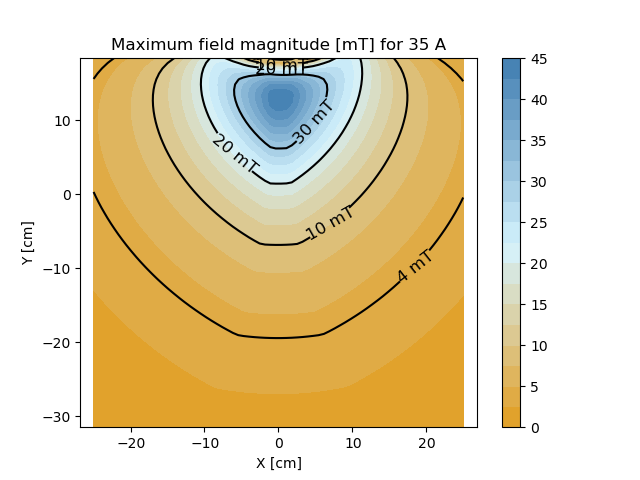

In [96]:
fig = plt.figure()

ax = fig.gca()
cs = ax.contour(x_hor*100, y_hor*100, z_hor*1000, [4, 10 ,20, 30], alpha=1.0, colors='black', vmin=max_field_hor.min(), vmax=max_field_hor.max())
s2 = ax.contourf(x_hor*100, y_hor*100, z_hor*1000, 20, cmap=cmp_blue_3col_inv, alpha=1.0, vmin=max_field_hor.min(), vmax=max_field_hor.max())

ax.clabel(cs, inline=1, fontsize=12, fmt='%1.0f mT')

ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
ax.set_xlim(pmin_hor[0],pmax_hor[0])
ax.set_ylim(pmin_hor[1],pmax_hor[1])
ax.set_title('Maximum field magnitude [mT] for 35 A')
ax.axis('equal')

fig.colorbar(s2)

plt.show()

In [ ]:
name = 'navion_35A_isolines.svg'
plt.savefig('/home/qboehler/Pictures/{}'.format(name),dpi=300)

In [163]:
#Define requirements for catheter steering

Br = 1.3 #magnet remanence [T]
l = 5.0e-3 #magnet length [m]
d = 2.33e-3 #outer diameter [m]
mu0 = 4*math.pi*(10**(-7)) # permeability of vacuum [H/m]
m = (math.pi*(d/2)**2*l*Br)/mu0 #magnetic dipole moment [Nm/T]

theta_des = 120 * math.pi/180 # desired max tip angle [rad]
L = 4.0e-2 #length of the catheter [m]
E = 15.0e6 #Young's modulus of the catheter [Pa]
I = math.pi * (d/2)**4 /4 #second moment of area of the cross-section [m^4]

#Compute maximum torque and field magnitude
tmax = theta_des * E * I / L #[N.m]
bmax = tmax / m #[T]

bmax = 0.015

print(tmax)
print(bmax)

0.001136275033022366
0.015000000000000001


In [166]:
#Horizontal plane
Nx = 100
Ny = 100
Nz = 1

#Build initial box
pmin_hor = np.array([-0.2,-0.2,0.])
pmax_hor = np.array([0.2,0.2,0.])

p_ws_3_bg_x_in, p_ws_3_bg_x_out, p_ws_3_bg_x_side, kappa_3_bg_x, mu_3_bg_x, gci_3_bg_x, ad_3_bg_x = Ws3DFieldDeterminationDiscr(Nx,Ny,Nz,pmin_hor,pmax_hor,-bmax,bmax,-35,35,model_navion,'ellipsoid')
p_hor, max_field_hor = ComputeMaxField(Nx,Ny,Nz,pmin_hor,pmax_hor,-35,35,model_navion)

x_hor = np.linspace(pmin_hor[0], pmax_hor[0], 70, endpoint=True)
y_hor = np.linspace(pmin_hor[1], pmax_hor[1], 70, endpoint=True)
z_hor = griddata((p_hor[:,0], p_hor[:,1]), max_field_hor/1000, (x_hor[None,:], y_hor[:,None]), method='linear')

<IPython.core.display.Javascript object>


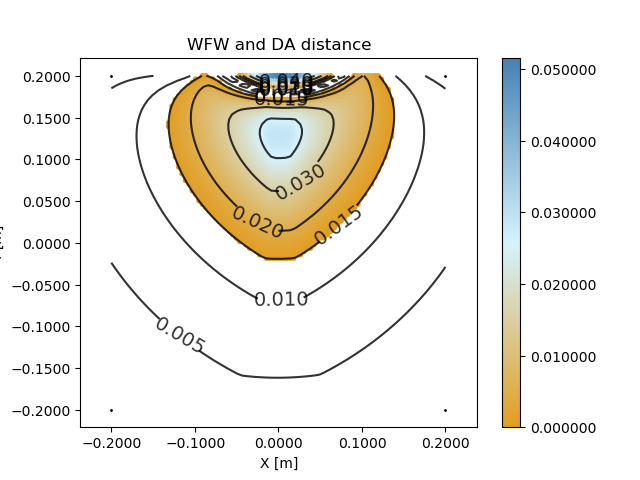

In [167]:
fig = plt.figure()

ax = fig.gca()
cs = ax.contour(x_hor, y_hor, z_hor, [0.005, 0.01, 0.015, 0.020, 0.030, 0.040], alpha=0.8, colors='black', vmin=max_field_hor.min()/1000, vmax=max_field_hor.max()/1000)
ax.clabel(cs, inline=1, fontsize=14, fmt='%1.3f')

s = ax.scatter(p_ws_3_bg_x_in[:,0],p_ws_3_bg_x_in[:,1],alpha=1., s = 10, c=ad_3_bg_x,cmap = cmp_blue_3col_inv,rasterized=True, vmin = 0, vmax = ad_3_bg_x.max())
ax.scatter(p_ws_3_bg_x_side[:,0],p_ws_3_bg_x_side[:,1], color='black',alpha=1., s = 1., rasterized=True)

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_xlim(pmin_hor[0],pmax_hor[0])
ax.set_ylim(pmin_hor[1],pmax_hor[1])
ax.set_title('WFW and DA distance')
ax.axis('equal')

plt.colorbar(s)
plt.show()

In [12]:
name = 'navion_35A.svg'
plt.savefig('/home/qboehler/Pictures/{}'.format(name),dpi=300)

# Experimental validation

## Functions for data processing

In [104]:
def EvaluateMaxInSensorPos(plate_height,model_mns,Imin,Imax):
# Prepare position transformation
    
    plate_height = 0. #height of plate in mns frame
    x_corr = 0.
    y_corr = 0.01
    t = [0.120+x_corr,0.20+y_corr,-plate_height] #Translation from calcube to mns frame

    Tcalcube_mns = np.array([[ 1., 0.,  0., t[0]],[0.,  1., 0., t[1]],[0.,0.,1.,t[2]],[0. , 0., 0. ,1.]])
    Tmns_calcube = np.linalg.inv(Tcalcube_mns)

    nx = 11
    ny = 11
    spacing = 0.024
    pos0 = np.array([0.,0.,0.])
    pos = np.empty((0,3))
    bmax = np.array([])

    # Generate list of positions in mns frame corresponding to sensors and evaluate max field in T at this location

    for X in range(nx):
        for Y in range(ny):

            # Position
            cX = spacing * (nx - 1) / 2.0
            cY = spacing * (ny - 1) / 2.0

            position_calcube_hom = np.array([X * spacing ,Y * spacing, 0., 1.])
            position_mns_hom = np.matmul(Tmns_calcube,position_calcube_hom)

            pos = np.append(pos, [position_mns_hom[0:3]], axis=0) 
            
            temp = ComputeMaxFieldInPos(model_mns,position_mns_hom[0:3],Imin,Imax)

            bmax = np.append(bmax, [temp], axis=0) 
        
    return pos, bmax

In [49]:
def MinMaxField(bmeas):
# Compute max field based on sensors measurement

    # Return min field and maximum field within the hull
    
    hull = ConvexHull(bmeas)
    simplices = hull.simplices
    org_triangles = [bmeas[s] for s in simplices]
    
    #Min
    eq = hull.equations
    dist_tri = np.abs(eq[:,3])
    
    i_min = np.argmin(dist_tri)
    bmin = dist_tri.min() * eq[i_min,0:3]
    
    #Max
    dist_simpl = np.linalg.norm(bmeas,axis=1)
    
    i_max = np.argmax(dist_simpl)
    bmax = bmeas[i_max,:]
    
    return bmin, bmax

In [50]:
# Compute for every sensors
def ComputeOrderedMinMaxMag(bmeas):

    bmin = np.empty((0,3))
    bmax = np.empty((0,3))

    for i in range(125):


        bmin_i, bmax_i = MinMaxField(bmeas[:,3*i:3*i+3])


        bmin = np.append(bmin, [bmin_i[0:3]], axis=0) 
        bmax = np.append(bmax, [bmax_i[0:3]], axis=0) 

    # Compute norms

    bmin_mag = np.transpose(np.reshape(np.apply_along_axis(np.linalg.norm, 1, bmin),(-1,1)))
    bmax_mag = np.transpose(np.reshape(np.apply_along_axis(np.linalg.norm, 1, bmax),(-1,1)))

    # Re-order sensors to match positions list

    order = np.loadtxt("experimental_data/sensors_connection.txt", dtype=int)

    bmin_mag_ordered = bmin_mag[:,order[:,0]-1] #reordering sensors to match order of tested position
    bmax_mag_ordered = bmin_mag[:,order[:,0]-1] #reordering sensors to match order of tested position
    
    return bmin_mag_ordered[0,0:121], bmax_mag_ordered[0,0:121]

## Data for neutral plane

In [51]:
bag = rosbag.Bag('experimental_data/measures_navion_pos_0.bag')
topics = get_available_topics(bag)
meas_field = topic_to_df(bag,'/field_array_raw','mag_msgs/FieldArrayStamped')
bmeas = meas_field.to_numpy()*1000 #measurement in mT

[ 8.26438799e+00 -1.63818771e-15 -4.43454965e+00]
[-10.  -29.1   1.2]


<IPython.core.display.Javascript object>


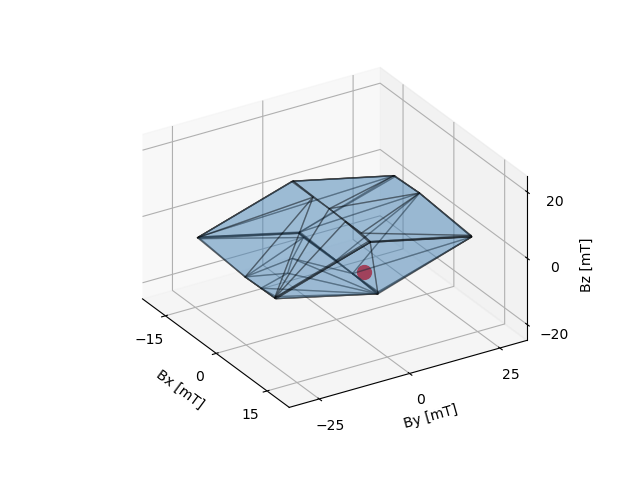

In [87]:
# Example on one sensor

id_sens = 1

bmin, bmax = MinMaxField(bmeas[:,3*id_sens:3*id_sens+3])

print(bmin)
print(bmax)

fig = plt.figure()
ax = fig.gca(projection='3d',proj_type = 'ortho')
#ax.scatter(bmeas[:,3*id_sens],bmeas[:,3*id_sens+1],bmeas[:,3*id_sens+2])
plotHull(ax,bmeas[:,3*id_sens:3*id_sens+3],'steelblue',0.3,inter=0.1,edge_color='black')
ax.scatter(bmin[0],bmin[1], bmin[2], color='red',alpha=1.,s=100)
#ax.scatter(bmax[0],bmax[1], bmax[2], color='green',alpha=1.,s=100)
ax.set_xlabel('Bx [mT]')
ax.set_ylabel('By [mT]')
ax.set_zlabel('Bz [mT]')


ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.zaxis.set_major_locator(plt.MaxNLocator(3))

plt.show()

In [53]:
# Compute for all sensors
bmin_mag_ordered, bmax_mag_ordered = ComputeOrderedMinMaxMag(bmeas)

<IPython.core.display.Javascript object>


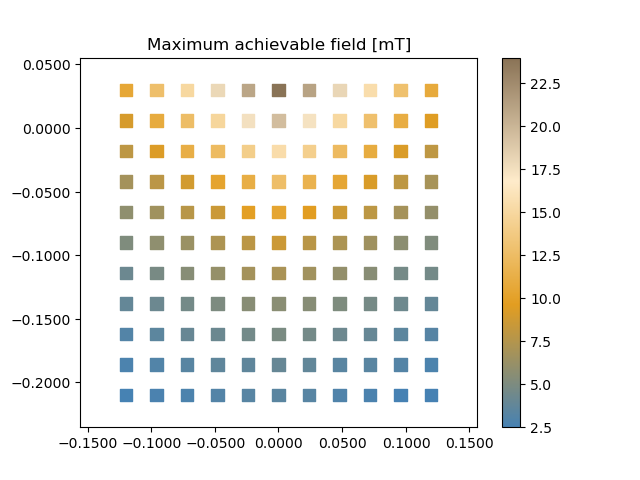

In [105]:
pos0, bmax0 = EvaluateMaxInSensorPos(0.,model_navion,-35,35)

fig = plt.figure()
ax = fig.gca()
s = ax.scatter(pos0[:,0],pos0[:,1], c=bmin_mag_ordered, marker="s", cmap = cmp_blue_4col, alpha=1.,s = 80, rasterized=True)
ax.axis('equal')
ax.set_title('Maximum achievable field [mT]')
fig.colorbar(s, ax=ax,shrink=1.)
plt.show()

In [112]:
# Compute estimation error

err = np.abs(bmax0*1000 - bmin_mag_ordered)
print(err)
print(np.mean(err))
print(np.std(err))

[0.38866932 0.52124258 0.65797209 0.42494843 0.66906581 0.46206413
 0.57112087 0.56387091 0.52545243 0.62452091 0.52875751 0.42898299
 0.54000076 0.57159155 0.49025313 0.63109483 0.43555776 0.60699396
 0.59473033 0.42408062 0.4749662  0.42271184 0.59964952 0.55669361
 0.45859469 0.57027319 0.53190342 0.62043287 0.46474016 0.6739157
 0.02276695 0.6905381  0.61379895 0.45432754 0.47793608 0.62788248
 0.61842839 0.44546783 0.52155183 0.56001492 0.52736999 0.49833635
 0.50772009 0.32777933 0.2754911  0.53824073 0.36862193 0.33555452
 0.16692436 0.51331082 0.30615595 0.89696086 0.43368119 0.06673237
 0.27356105 0.17087149 0.23318922 0.10257316 0.28695948 0.03145653
 0.18069993 0.13910183 0.28337932 0.2926275  0.96701633 1.13076778
 0.28530577 0.42422747 0.32316842 0.34813019 0.31613742 0.59284965
 0.44730297 0.660941   0.49994348 0.44160782 0.51560298 0.59435484
 0.73334612 0.57582564 0.62066182 0.61413229 0.65184073 0.55504699
 0.48602513 0.741123   0.60104249 0.61128073 0.68727646 0.52761

<IPython.core.display.Javascript object>


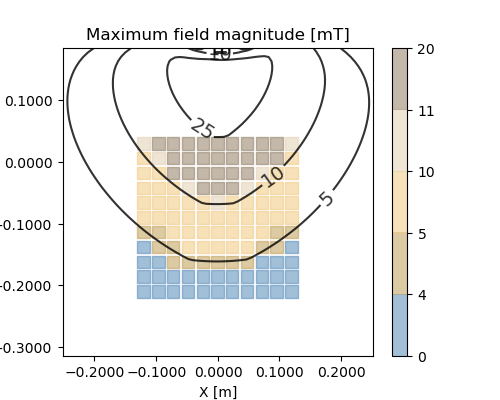

In [80]:
vals=[0,4,5,10,11,20]
norm = mpl.colors.BoundaryNorm(vals, cmp_blue_4col.N)

fig = plt.figure(figsize=(5, 4))

ax = fig.gca()
cs = ax.contour(x_hor, y_hor, z_hor*1000, [5, 10, 25], alpha=0.8, colors='black', vmin=max_field_hor.min(), vmax=max_field_hor.max())
ax.clabel(cs, inline=1, fontsize=14, fmt='%1.0f')
s = ax.scatter(pos0[:,0],pos0[:,1], c=bmin_mag_ordered, marker="s", cmap = cmp_blue_4col, norm=norm, alpha=0.5,s = 80, rasterized=True)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_xlim(np.min(pos0[:,0]),np.max(pos0[:,0]))
ax.set_ylim(np.min(pos0[:,1]),np.max(pos0[:,1]))
ax.set_title('Maximum field magnitude [mT]')
ax.axis('equal')
fig.colorbar(s, ax=ax,shrink=1.)

plt.show()

In [38]:
name = 'navion_35A_plane0.svg'
plt.savefig('/home/qboehler/Pictures/{}'.format(name),dpi=300)

## Data for other planes

In [68]:
bag = rosbag.Bag('experimental_data/measures_navion_pos_1.bag')
topics = get_available_topics(bag)
meas_field = topic_to_df(bag,'/field_array_raw','mag_msgs/FieldArrayStamped')
bmeas1 = meas_field.to_numpy()*1000 #measurement in T

bag = rosbag.Bag('experimental_data/measures_navion_pos_m1.bag')
topics = get_available_topics(bag)
meas_field = topic_to_df(bag,'/field_array_raw','mag_msgs/FieldArrayStamped')
bmeasm1 = meas_field.to_numpy()*1000 #measurement in T

bag = rosbag.Bag('experimental_data/measures_navion_pos_2.bag')
topics = get_available_topics(bag)
meas_field = topic_to_df(bag,'/field_array_raw','mag_msgs/FieldArrayStamped')
bmeas2 = meas_field.to_numpy()*1000 #measurement in T

bag = rosbag.Bag('experimental_data/measures_navion_pos_m2.bag')
topics = get_available_topics(bag)
meas_field = topic_to_df(bag,'/field_array_raw','mag_msgs/FieldArrayStamped')
bmeasm2 = meas_field.to_numpy()*1000 #measurement in T

In [69]:
bmin1_mag_ordered, bmax1_mag_ordered = ComputeOrderedMinMaxMag(bmeas1)
bmin2_mag_ordered, bmax2_mag_ordered = ComputeOrderedMinMaxMag(bmeas2)
bminm1_mag_ordered, bmaxm1_mag_ordered = ComputeOrderedMinMaxMag(bmeasm1)
bminm2_mag_ordered, bmaxm2_mag_ordered = ComputeOrderedMinMaxMag(bmeasm2)

<IPython.core.display.Javascript object>


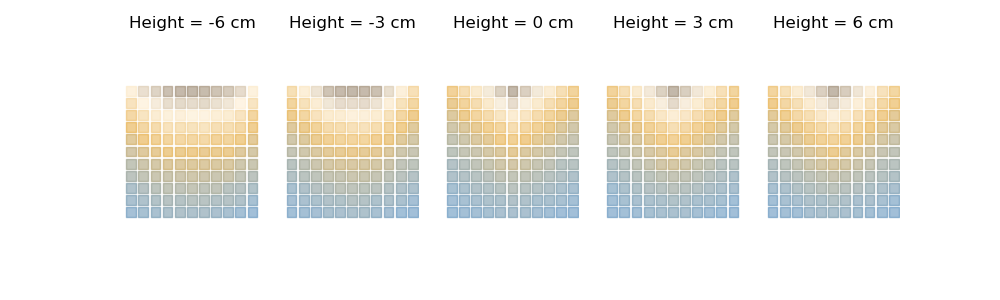

In [113]:
fig = plt.figure(figsize=(10, 3))

# Pos -2
posm2, bmaxm2 = EvaluateMaxInSensorPos(-5.76e-3,model_navion,-35,35)
ax = fig.add_subplot(151)
s = ax.scatter(posm2[:,0]*100,posm2[:,1]*100, c=bminm2_mag_ordered, marker="s", cmap = cmp_blue_4col, alpha=0.5,s = 50, rasterized=True)
ax.set_title('Height = -6 cm')
ax.axis('equal')
ax.axis('off')


# Pos -1
posm1, bmaxm1 = EvaluateMaxInSensorPos(-2.88e-3,model_navion,-35,35)
ax = fig.add_subplot(152)
s = ax.scatter(posm1[:,0]*100,posm1[:,1]*100, c=bminm1_mag_ordered, marker="s", cmap = cmp_blue_4col, alpha=0.5,s = 50, rasterized=True)
ax.set_title('Height = -3 cm')
ax.axis('equal')
ax.axis('off')

# Pos 0
pos0, bmax0 = EvaluateMaxInSensorPos(0.,model_navion,-35,35)
ax = fig.add_subplot(153)
s = ax.scatter(pos0[:,0]*100,pos0[:,1]*100, c=bmin_mag_ordered, marker="s", cmap = cmp_blue_4col, alpha=0.5,s = 50, rasterized=True)
ax.set_title('Height = 0 cm')
ax.axis('equal')
ax.axis('off')

# Pos 1
pos1, bmax1 = EvaluateMaxInSensorPos(2.88e-3,model_navion,-35,35)
ax = fig.add_subplot(154)
s = ax.scatter(pos1[:,0]*100,pos1[:,1]*100, c=bmin1_mag_ordered, marker="s", cmap = cmp_blue_4col, alpha=0.5,s = 50, rasterized=True)
ax.set_title('Height = 3 cm')
ax.axis('equal')
ax.axis('off')

# Pos 2
pos2, bmax2 = EvaluateMaxInSensorPos(5.76e-3,model_navion,-35,35)
ax = fig.add_subplot(155)
s = ax.scatter(pos2[:,0]*100,pos2[:,1]*100, c=bmin2_mag_ordered, marker="s", cmap = cmp_blue_4col, alpha=0.5,s = 50, rasterized=True)
ax.set_title('Height = 6 cm')
ax.axis('equal')
ax.axis('off')


plt.show()

In [61]:
name = 'navion_35A_multiple_plane.svg'
plt.savefig('/home/qboehler/Pictures/{}'.format(name),dpi=300)

In [115]:
err0 = np.abs(bmax0*1000 - bmin_mag_ordered)
err1 = np.abs(bmax1*1000 - bmin1_mag_ordered)
err2 = np.abs(bmax2*1000 - bmin2_mag_ordered)
errm1 = np.abs(bmaxm1*1000 - bminm1_mag_ordered)
errm2 = np.abs(bmaxm2*1000 - bminm2_mag_ordered)


err = np.concatenate((errm2,errm1,err0,err1,err2))

print(err)
print(np.mean(err))
print(np.std(err))

[0.4004482  0.41747519 0.549466   0.27845077 0.51462021 0.25315627
 0.24927499 0.20225207 0.08030454 0.01697356 0.32907796 0.40848023
 0.43608875 0.44540874 0.2985661  0.39523318 0.23508106 0.1981479
 0.13016494 0.11152719 0.36748738 0.23459456 0.54238388 0.51324562
 0.4409451  0.33060832 0.5894878  0.49214762 0.56371929 0.72986145
 0.36319988 0.81521299 1.26856764 0.37745006 0.44505824 0.46899053
 0.74436977 0.6595075  0.81249427 1.03428761 1.13490458 1.48778085
 1.77860554 2.44118592 0.32989581 0.59865949 0.66589737 0.83726125
 1.0801014  1.51757811 1.73567036 2.54410901 3.22980853 3.64395653
 4.79451098 0.45099424 0.44297773 0.46677662 0.74899497 1.08480572
 1.49990848 1.93028412 2.71524241 3.43306493 4.87617357 6.32338405
 0.3570713  0.47939149 0.69500297 0.85429287 1.1426599  1.67668489
 1.56231957 2.33851823 3.07373852 3.97942007 5.39289525 0.57499161
 0.6473311  0.54299361 0.87308614 0.88571266 1.06205729 1.43116972
 1.73134847 1.97558658 2.30515846 3.094812   0.61678698 0.38681